# [Parameter efficient fine tuning using LORA](https://arxiv.org/pdf/2106.09685.pdf)

LoRA is a relatively new technique for adapting LLMs to specific downstream tasks. LoRA works by freezing the pre trained model weights and and injecting trainable rank decomposition matrices into each layer of the transformer architecture. This greatly reduces the number of trainable parameters required, and hence reducing the resources required i.e. reduced memory usage while training, and reduced disk space for checkpoints. This allows for fine tuning of relatively large models using basic hardware. This example uses [huggingface PEFT](https://huggingface.co/docs/diffusers/training/lora) libraries that use the LORA technique for parameter efficient fine tuning of Roberta-Large (355M parameters).

This work is built on the premise that pre trained models have a low intrinsic "rank" i.e. The number of linearly independent rows or columns. Therefore it follow that changes in these pre trained weights as a result of task specific fune tuning must also has a low intrinsic rank.

Assuming the base model weights to be $W_ox$ and $\varDelta Wx$ to be the changes due to fine tuning, then the fine tuned weights can be expressed as $h=Wox+\varDelta Wx$. Further the LoRA adapters create a low rank decomposition $\varDelta Wx = BA$ resulting in $h=W_0x+BAx$

Concrete example:
If a weight matrix is of size = $d=5000$, $k=3000$, $d \times k = 15,000,000$ parameters; using $r=6$ we get $(d \times r) + (r \times k) = 30000 + 18000 = 48,000$ parameters, which is 0.3% of the size



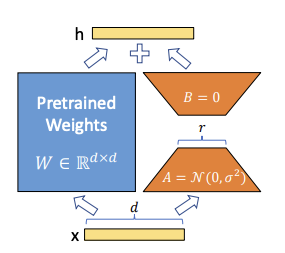

In [1]:
!pip install -q -U datasets
!pip install -q -U transformers[torch]
!pip install -q -U evaluate
!pip install -q -U peft
!pip install -q -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 58.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import evaluate
import torch
import numpy as np




## Load IMDB Dataset
reduce dataset size to 10K to reduce tuning time

In [4]:
imdb = load_dataset("imdb")
for key in imdb.keys():
    imdb[key] = imdb[key].shuffle().select((range(10000)))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Set LORA specific hyperparameters

`r` is the rank of the

In [6]:
# LoRA-specific
r = 8                 # rank of the low-rank adapters (size of A/B factors)
lora_alpha = 32       # scaling factor applied to the LoRA update (often α/r is used internally)
lora_dropout = 0.1    # dropout applied on the LoRA path during training

# Model/task-specific
model_checkpoint = "roberta-large"  # base pretrained model to adapt with LoRA
lr = 1e-5                           # learning rate for optimizer
batch_size = 8                      # per-device batch size
num_epochs = 2                      # number of full passes over the training set


## This function gets used during evaluation

In [5]:
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


## Tokenize input text

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
metric = evaluate.load('accuracy')
# ^ Load the Accuracy metric from the `evaluate` library (returns a Metric object).

def compute_metrics(p):
    predictions, labels = p                 # unpack model outputs and true labels
    predictions = np.argmax(predictions, axis=1)
    # ^ take the argmax over the class dimension to get predicted class IDs
    #   (assumes `predictions` are logits/probs shaped [batch, num_classes])

    return metric.compute(predictions=predictions, references=labels)
    # ^ compute and return accuracy as a dict, e.g., {'accuracy': 0.92}


In [15]:
# Sanity check
imdb['train'][0]

{'text': 'This started bad, got worse, and by the time the girl attacked the old lady at the end i literally wanted to take the DVD to the person we borrowed it off and choke the C**T to death with it. Avoid this film, a little bit of good cinematography and some naked shots, would be almost acceptable if i was 14 and had not seen Jenna Jameson naked a million times. If anyone feels the need to watch this film, i would strongly recommend you spend the time more appropriately, as an example i would say trying to cram a Lego house into your bum with no lube would be a good start. I hear that this film was not the original version, i would very much like to view the original, as it seems that this cut version is devoid of all plot, and apparently most of the nudity, can someone please tell me how i can get in touch with Christian Viel he owes me an hour of my life back!',
 'label': 0}

In [12]:
def tokenize(examples):
    # Tokenize a batch dict `examples` using the HF tokenizer.
    # Expects a key "text" containing a list of strings.
    tokenized_inputs = tokenizer(
        examples["text"],          # input texts (batch)
        truncation=True,           # cut off sequences longer than max_length
        padding="max_length",      # pad all sequences to exactly max_length
        max_length=512             # fixed sequence length (tokens)
    )

    return tokenized_inputs       # returns a dict (e.g., input_ids, attention_mask, etc.)

tokenized_imdb = imdb.map(tokenize, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Load classification model.

`AutoModelForSequenceClassification` is a Generic huggingface transformers library that has a classification head on top of model outputs. We freeze the model layers explicitly since the LORA adapters will be used to train smaller weight matrices

In [16]:
id2label = {
    0: "neg",
    1: "pos"
}
# ^ map class IDs → human-readable labels (for config/outputs)

label2id = {
    "neg": 0,
    "pos": 1
}
# ^ inverse map labels → IDs (for training/inference consistency)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,          # e.g., "roberta-large"
    num_labels=2,              # binary classification
    id2label=id2label,         # attach label mappings to config
    label2id=label2id
)
# ^ loads a pretrained encoder with a classification head sized to 2 classes

for name, param in model.named_parameters():
    param.requires_grad = False
# ^ freeze all base model parameters (no gradient updates) —
#   useful before adding LoRA/adapters so only adapters train


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## LORA setup
setup the lora config and call function to get the peft version of the model that adds the extra adapters and layers

In [17]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # sequence classification task (guides which layers get LoRA)
    inference_mode=False,         # we're training adapters (not inference-only)
    r=r,                          # LoRA rank (bottleneck dimension of A/B)
    lora_alpha=lora_alpha,        # scaling applied to the LoRA update (often α/r internally)
    lora_dropout=lora_dropout     # dropout on the LoRA branch during training
)


In [18]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


In [19]:
_= model.to("cuda")

In [22]:
!nvidia-smi

Thu Oct  9 03:05:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             75W /  400W |    7117MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Setup training arguments and train model

In [20]:
training_args = TrainingArguments(
    # directory to save checkpoints, config, and logs
    output_dir="roberta-large-lora-sequence-classification",

    learning_rate=lr,  # base learning rate

    # batch sizes per GPU/CPU device for train/eval
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    num_train_epochs=num_epochs,  # total epochs
    weight_decay=0.01,            # L2-style regularization

    # run evaluation at the end of each epoch
    eval_strategy="epoch",

    # save a checkpoint at the end of each epoch
    save_strategy="epoch",

    logging_steps=10,             # log every N steps
    load_best_model_at_end=True,  # restore best checkpoint after training
    report_to='none'              # disable external loggers (W&B/Comet/TensorBoard)
)


In [21]:
# initialize HF Trainer with model, args, datasets, and metrics
trainer = Trainer(
    model=model,                           # model to train/evaluate
    args=training_args,                    # TrainingArguments
    # training split (tokenized)
    train_dataset=tokenized_imdb["train"],
    # evaluation split (tokenized)
    eval_dataset=tokenized_imdb["test"],
    compute_metrics=compute_metrics,       # function returning eval metrics dict
)

trainer.train()  # run the training loop


Epoch,Training Loss,Validation Loss,Accuracy
1,0.297600,0.216006,0.951900
2,0.086200,0.217421,0.952600


TrainOutput(global_step=2500, training_loss=0.2824249640494585, metrics={'train_runtime': 1392.3633, 'train_samples_per_second': 14.364, 'train_steps_per_second': 1.796, 'total_flos': 1.875155902464e+16, 'train_loss': 0.2824249640494585, 'epoch': 2.0})

## Run a sample evaluation

In [23]:
# Run an example inference on a few rows in the test dataset
examples = tokenized_imdb["test"].select(range(5))

# Get predictions (logits) and true labels for these rows
result = trainer.predict(examples)

# Iterate over each example and its corresponding TRUE label id
for ex, pred in zip(examples, result.label_ids):
    print(ex['text'][:150], id2label[pred])  # show first 150 chars and its label name


INFERNO starts off with a fairly impressive for a TVM starscape effect . We`re also introduced to a scientist who`s called Heller . Don`t you get it ? neg
I had watched this on Italian TV as a kid and recall being fond of it – in view of its mixing live-action with animation; however, it was universally  neg
I know that Trey Parker and Matt Stone really hate celebrities and spoof them in every single episode of South Park (if not showing them, then mention neg
simply i just watched this movie just because of Sarah & am also giving these 4 stars just because of her,on the other side This movie was easily one  neg
"The Journey" is a very good film. Produced in the spring of 1958, in Vienna, and released in 1959, this movie was quite popular in his early years. D pos


## Size of checkpoints

In [24]:
# print and check size of checkpoint. As expected the model size is much smaller that a typical bert checkpoint
!ls -lh roberta-large-lora-sequence-classification/checkpoint-1250/


total 22M
-rw-r--r-- 1 root root  873 Oct  9 02:53 adapter_config.json
-rw-r--r-- 1 root root 7.1M Oct  9 02:53 adapter_model.safetensors
-rw-r--r-- 1 root root  15M Oct  9 02:53 optimizer.pt
-rw-r--r-- 1 root root 5.1K Oct  9 02:53 README.md
-rw-r--r-- 1 root root  15K Oct  9 02:53 rng_state.pth
-rw-r--r-- 1 root root 1.5K Oct  9 02:53 scheduler.pt
-rw-r--r-- 1 root root  20K Oct  9 02:53 trainer_state.json
-rw-r--r-- 1 root root 5.8K Oct  9 02:53 training_args.bin


In [25]:
# Roberta large is ~1.3GB, and the typical training checkpoint is ~4-5GB with optimizer and scheduler state
param_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
print("Model params size (MB):", param_bytes/1024/1024)

Model params size (MB): 1362.609390258789


In [26]:
# 7MB is a lot smaller than 4-5GB!
from peft import get_peft_model_state_dict
adapter_bytes = sum(t.numel()*t.element_size() for t in get_peft_model_state_dict(model).values())
print("LoRA adapter size (MB):", adapter_bytes/1024/1024)


LoRA adapter size (MB): 7.011726379394531


### What actually speeds up

* **Fewer trainable params → smaller optimizer states & gradients.**

  * On multi-GPU, **less gradient communication** → better scaling (often **~1.2–2×** improvement in distributed throughput).
  * **Cheaper optimizer step** (fewer tensors to update).
* **Lower memory → larger batch/sequence length.**

  * You can bump **batch size** or **context length**, which increases tokens/sec and can **reduce total wall-clock time** to a target quality.
* **Smaller checkpoints** (MBs vs GBs) → faster save/load in experiments.

### What usually doesn’t change much

* **Forward/backward compute through the base model** still happens.

  * The heavy matmuls run unchanged; you just don’t compute/update gradients for frozen weights.
  * Net per-step speedup is often **modest (0–10%)** vs full fine-tuning on a single GPU.

### When LoRA feels “faster” overall

* You use the freed VRAM to **double/triple batch size** → **1.5–3×** higher throughput.
* You train **distributed** and benefit from **smaller grad comms**.
* You iterate faster due to **tiny checkpoints** and **quick restarts**.

### When it won’t help much

* Tiny models where memory wasn’t a bottleneck.
* CPU/data-loader bound pipelines.
* If you keep the same small batch and single-GPU setup, expect **little per-step speed gain**.

**TL;DR:** LoRA rarely gives big per-step speedups by itself, but it **often finishes training faster** because it frees memory (bigger batches/seq), reduces communication, and shrinks optimizer/checkpoints.
